# West Main Street Analysis - 1861928

<span style="font-size: 1.2em;">Created by: bergstromn@kalamazoocity.org</span>   
<span style="font-size: 1.2em;">Created on: 2024-12-13</span>   
<span style="font-size: 1.2em;">Organization: City of Kalamazoo</span>   
<span style="font-size: 1.2em;">Created by: bergstromn@kalamazoocity.org</span>
<span style="font-size: 1.2em;">Analysis ID: 1861928</span>

**Analysis Type:** Corridor Studies   
**Unit of Measurement:** Miles   
**Mode of Travel:** All Vehicles    
**Zone Library Type(s):** OSM (Feb 2023)     
**Output Type:** StL All Vehicles Volume   
   
Data Periods: **Jan 01, 2022 - Dec 31, 2023**   
Total Traffic Volume: **3,687,000**

### Map Of Study Location

In [112]:
import geopandas as gpd
gdf = gpd.read_file('west_main_corridor.geojson')
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          53 non-null     object  
 1   segment_id  53 non-null     int32   
 2   name        53 non-null     object  
 3   segment_ty  53 non-null     object  
 4   geometry    53 non-null     geometry
dtypes: geometry(1), int32(1), object(3)
memory usage: 2.0+ KB


In [141]:
gdf.to_crs(epsg=3857, inplace=True)
gdf.total_bounds

array([-9535805.17429403,  5204747.15539218, -9528239.97866332,
        5205463.82515336])

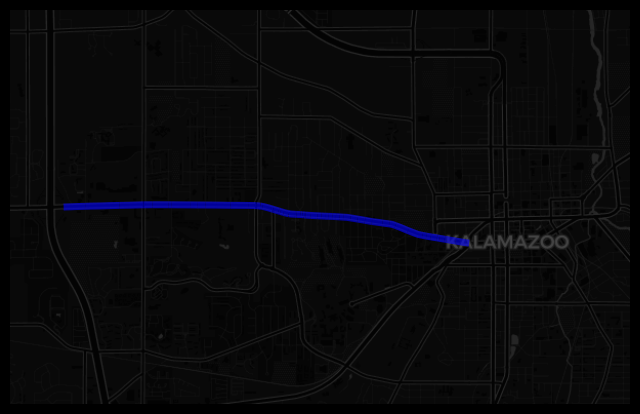

In [229]:
import matplotlib.pyplot as plt
import contextily as cx
ax = gdf.plot(figsize=(8, 10), linewidth=5, color='blue', alpha=0.6)
ax.set_xlim(left=-9536805, right=-9525239);
ax.set_ylim(bottom=5201747, top=5209100);
# gdf.plot(ax=ax, color='blue', alpha=0.6, linewidth=5)
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter, attribution=False, zoom=13)

## Raw CSV Data

Summary of records and clip of CSV 

## Data Analysis

#### Loading Data

#### Cleaning Data

#### Summary Data Table

#### Remove Outliers Analysis

#### Traffic Data Visualization

#### Spatial Data Visualization

## Conclusion